In [ ]:
# Install
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=9b28d0be2dcc65a96daed4a63d9d1c73868c6f1cf19cb497c8463cc1a55c1a30
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [ ]:
# Data Analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Fuzzy Logic
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Dataset
from tensorflow.keras.datasets import fashion_mnist

# Metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Data Conversion
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalization -> [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train[0].shape

4422102/4422102 [==============================] - 0s 0us/step


(28, 28)

In [ ]:
# Test slicing at window corner (7,7) to (13,13)
x_train[0], x_train[0][7:14, 7:14]

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

In [ ]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
def pixel_reduction_flatten(img):
    '''
    - Reduce 28x28 -> 4x4 using average value within 7x7 window
    - Flatten into 1d array
    '''
    result = []
    for row in range(4):
        for col in range(4):
            average_pixel_value = img[7 * row : 7 * (row + 1),
                                      7 * col : 7 * (col + 1)].sum() / 49
            result.append(average_pixel_value)
    return result

In [ ]:
x_train_new = []
x_test_new = []

for i in range(len(x_train)):
    x_train_new.append(pixel_reduction_flatten(x_train[i]))

for i in range(len(x_test)):
    x_test_new.append(pixel_reduction_flatten(x_test[i]))

len(x_train_new), len(y_train), len(x_test_new), len(y_test)

(60000, 60000, 10000, 10000)

## Distribution of pixel values for each apparel

In [ ]:
train_df = pd.concat([
    pd.DataFrame(x_train_new, columns=['00', '01', '02', '03', '10', '11', '12', '13', '20', '21', '22', '23', '30', '31', '32', '33']),
    pd.Series(y_train, name='apparel')],
    axis='columns'
)
train_df

,00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33,apparel
0,0.000000,0.000800,0.209044,0.042017,0.000000,0.122289,0.842417,0.664266,0.425050,0.680192,0.806322,0.742377,0.289796,0.490276,0.449460,0.337895,9
1,0.179832,0.630092,0.628011,0.321409,0.242577,0.687555,0.669308,0.348139,0.000880,0.685874,0.815606,0.048419,0.000320,0.662985,0.781433,0.068107,0
2,0.000000,0.298599,0.355022,0.000000,0.000000,0.250100,0.299160,0.000000,0.000000,0.260504,0.313165,0.000000,0.000000,0.232893,0.284434,0.000000,0
3,0.071549,0.561265,0.539096,0.043057,0.000800,0.403121,0.361265,0.001281,0.002961,0.375830,0.430412,0.015686,0.047539,0.373029,0.427771,0.078752,3
4,0.000000,0.504682,0.486355,0.000000,0.000000,0.626010,0.565666,0.000000,0.000000,0.699720,0.681313,0.000000,0.000000,0.672589,0.660584,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.000000,0.000000,0.096279,0.104922,0.000480,0.000160,0.000880,0.269468,0.180952,0.158864,0.160304,0.242897,0.141737,0.214646,0.042017,0.064106,5
59996,0.000000,0.449140,0.624970,0.000000,0.000000,0.475950,0.523890,0.000000,0.000000,0.407603,0.379512,0.000000,0.000000,0.296279,0.264906,0.000000,1
59997,0.000000,0.624330,0.545258,0.000000,0.000000,0.685394,0.698039,0.000000,0.000000,0.699160,0.662905,0.000000,0.000000,0.572069,0.518527,0.000000,3
59998,0.071629,0.268988,0.270188,0.076991,0.195838,0.244818,0.247859,0.206403,0.033774,0.265786,0.268187,0.035294,0.002241,0.246979,0.245778,0.001120,0


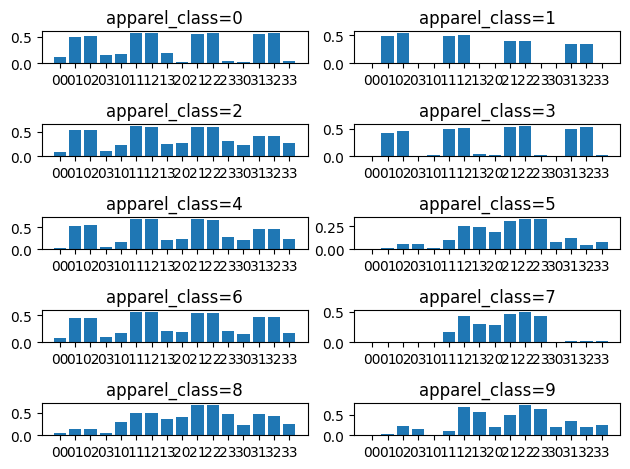

In [ ]:
fig, ax = plt.subplots(5, 2)

# Get average pixel_value for each apparel
average_pixel_value = train_df.groupby('apparel').mean()

for label, row in average_pixel_value.iterrows():
    ax[label // 2, label % 2].bar(x=average_pixel_value.columns, height=row)
    ax[label // 2, label % 2].set_title(f'apparel_class={label}')

plt.tight_layout()

In [ ]:
average_pixel_value

,00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
apparel,,,,,,,,,,,,,,,,
0,0.121963,0.506012,0.516915,0.148159,0.171017,0.569890,0.568789,0.197686,0.030295,0.557044,0.576898,0.043115,0.022233,0.559737,0.575920,0.044050
1,0.002912,0.478976,0.541556,0.004388,0.005424,0.485034,0.511762,0.007173,0.006054,0.404111,0.404752,0.007568,0.005575,0.344907,0.349260,0.007034
2,0.089228,0.525051,0.530937,0.107256,0.224858,0.619356,0.599713,0.258268,0.274168,0.597714,0.586596,0.308288,0.238197,0.403806,0.403576,0.260205
3,0.006897,0.429865,0.450769,0.013464,0.018910,0.491449,0.509175,0.032518,0.019020,0.527545,0.552740,0.028933,0.008630,0.501980,0.536072,0.014397
4,0.035357,0.522814,0.545527,0.048157,0.170066,0.692136,0.679726,0.207516,0.235571,0.687012,0.673811,0.280033,0.209217,0.469676,0.471504,0.237086
5,0.000050,0.009303,0.054821,0.054068,0.009495,0.096439,0.249578,0.244416,0.184674,0.302047,0.329160,0.328582,0.079324,0.125251,0.044621,0.075939
6,0.073114,0.448252,0.457136,0.090572,0.177710,0.562884,0.555450,0.209579,0.184179,0.545908,0.545659,0.216491,0.144793,0.459868,0.469987,0.166977
7,0.000001,0.000269,0.009232,0.002841,0.010597,0.167407,0.430202,0.300186,0.287382,0.469506,0.501238,0.436566,0.011104,0.021879,0.019428,0.015271
8,0.044008,0.135343,0.142652,0.058366,0.298604,0.498327,0.496160,0.363730,0.416944,0.677961,0.673868,0.481385,0.227239,0.464054,0.435785,0.242492


### Unique pixels combination for each apparel

| Apparel | Unique Pixels |
| ------- | ------------- |
| 0 | 02->white, 13->grey, 31->white |
| 1 | 02->white, 20->black, 31->grey |
| 2 | 02->white, 03->grey, 33->white |
| 3 | 13->black, 31->white |
| 4 | 03->black, 31->white, 33->white |
| 5 | 02->grey, 20->grey, 31->grey |
| 6 | 02->white, 03->grey, 31->white |
| 7 | 02->black, 20->white, 31->black |
| 8 | 11->white, 13->white, 20->white |
| 9 | 11->black, 13->white, 20->grey |

Pixel used: 02, 03, 11, 13, 20, 31, 33

<ipython-input-11-a7eb1c453337>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_pixel_value = train_df.groupby('apparel')['02', '03', '11', '13', '20', '31', '33'].mean()


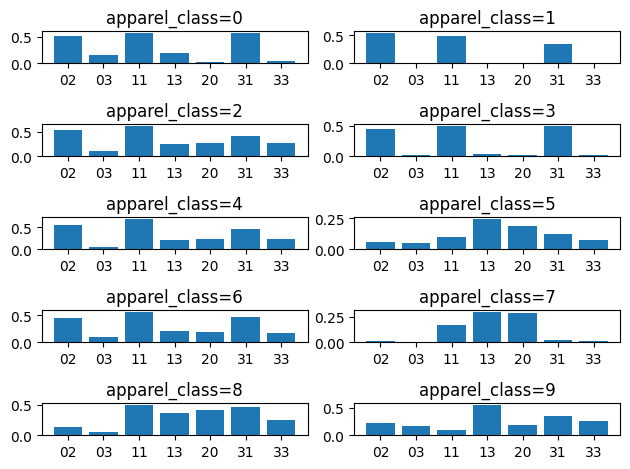

In [ ]:
# Check Combinations
fig, ax = plt.subplots(5, 2)

average_pixel_value = train_df.groupby('apparel')['02', '03', '11', '13', '20', '31', '33'].mean()

for label, row in average_pixel_value.iterrows():
    ax[label // 2, label % 2].bar(x=average_pixel_value.columns, height=row)
    ax[label // 2, label % 2].set_title(f'apparel_class={label}')

plt.tight_layout()

# Fuzzy Logic

In [ ]:
# Define Antecedents and Consequents
pixel_brightness_02 = ctrl.Antecedent(np.arange(0, 1, 0.01), 'pixel_brightness_02')
pixel_brightness_03 = ctrl.Antecedent(np.arange(0, 1, 0.01), 'pixel_brightness_03')
pixel_brightness_11 = ctrl.Antecedent(np.arange(0, 1, 0.01), 'pixel_brightness_11')
pixel_brightness_13 = ctrl.Antecedent(np.arange(0, 1, 0.01), 'pixel_brightness_13')
pixel_brightness_20 = ctrl.Antecedent(np.arange(0, 1, 0.01), 'pixel_brightness_20')
pixel_brightness_31 = ctrl.Antecedent(np.arange(0, 1, 0.01), 'pixel_brightness_31')
pixel_brightness_33 = ctrl.Antecedent(np.arange(0, 1, 0.01), 'pixel_brightness_33')
fashion_item = ctrl.Consequent(np.arange(0, 9, 0.01), 'fashion_item')

In [ ]:
# # Antecedent Fuzzification
# pixel_brightness_02['black'] = fuzz.gaussmf(pixel_brightness_02.universe, mean=0, sigma=0.1)
# pixel_brightness_02['grey'] = fuzz.gaussmf(pixel_brightness_02.universe, mean=0.2, sigma=0.1)
# pixel_brightness_02['white'] = fuzz.sigmf(pixel_brightness_02.universe, b=0.4, c=20)

# pixel_brightness_03['black'] = fuzz.gaussmf(pixel_brightness_03.universe, mean=0, sigma=0.03)
# pixel_brightness_03['grey'] = fuzz.gaussmf(pixel_brightness_03.universe, mean=0.07, sigma=0.03)
# pixel_brightness_03['white'] = fuzz.sigmf(pixel_brightness_03.universe, b=0.1, c=20)

# pixel_brightness_11['black'] = fuzz.gaussmf(pixel_brightness_11.universe, mean=0, sigma=0.1)
# pixel_brightness_11['grey'] = fuzz.gaussmf(pixel_brightness_11.universe, mean=0.2, sigma=0.1)
# pixel_brightness_11['white'] = fuzz.sigmf(pixel_brightness_11.universe, b=0.45, c=20)

# pixel_brightness_13['black'] = fuzz.gaussmf(pixel_brightness_13.universe, mean=0, sigma=0.1)
# pixel_brightness_13['grey'] = fuzz.gaussmf(pixel_brightness_13.universe, mean=0.15, sigma=0.1)
# pixel_brightness_13['white'] = fuzz.sigmf(pixel_brightness_13.universe, b=0.3, c=20)

# pixel_brightness_20['black'] = fuzz.gaussmf(pixel_brightness_20.universe, mean=0, sigma=0.1)
# pixel_brightness_20['grey'] = fuzz.gaussmf(pixel_brightness_20.universe, mean=0.15, sigma=0.1)
# pixel_brightness_20['white'] = fuzz.sigmf(pixel_brightness_20.universe, b=0.3, c=20)

# pixel_brightness_31['black'] = fuzz.gaussmf(pixel_brightness_31.universe, mean=0, sigma=0.1)
# pixel_brightness_31['grey'] = fuzz.gaussmf(pixel_brightness_31.universe, mean=0.25, sigma=0.2)
# pixel_brightness_31['white'] = fuzz.sigmf(pixel_brightness_31.universe, b=0.4, c=20)

# pixel_brightness_33['black'] = fuzz.gaussmf(pixel_brightness_33.universe, mean=0, sigma=0.1)
# pixel_brightness_33['grey'] = fuzz.gaussmf(pixel_brightness_33.universe, mean=0.08, sigma=0.1)
# pixel_brightness_33['white'] = fuzz.sigmf(pixel_brightness_33.universe, b=0.2, c=20)

In [ ]:
# Antecedent Fuzzification Fine Tuned
pixel_brightness_02['black'] = fuzz.trimf(pixel_brightness_02.universe,[0.0,0.0,0.1])
pixel_brightness_02['grey'] = fuzz.trimf(pixel_brightness_02.universe, [0.0,0.2,0.4])
pixel_brightness_02['white'] = fuzz.sigmf(pixel_brightness_02.universe, b=0.4, c=20)

pixel_brightness_03['black'] = fuzz.trimf(pixel_brightness_03.universe, [0.0,0.0,0.03])
pixel_brightness_03['grey'] = fuzz.trimf(pixel_brightness_03.universe, [0.0,0.07,0.1])
pixel_brightness_03['white'] = fuzz.sigmf(pixel_brightness_03.universe, b=0.1, c=20)

pixel_brightness_11['black'] = fuzz.trimf(pixel_brightness_11.universe, [0.0,0.0,0.1])
pixel_brightness_11['grey'] = fuzz.trimf(pixel_brightness_11.universe, [0.0,0.2,0.45])
pixel_brightness_11['white'] = fuzz.sigmf(pixel_brightness_11.universe, b=0.45, c=20)

pixel_brightness_13['black'] = fuzz.trimf(pixel_brightness_13.universe, [0.0,0.0,0.1])
pixel_brightness_13['grey'] = fuzz.trimf(pixel_brightness_13.universe, [0.0,0.15,0.3])
pixel_brightness_13['white'] = fuzz.sigmf(pixel_brightness_13.universe, b=0.3, c=20)

pixel_brightness_20['black'] = fuzz.trimf(pixel_brightness_20.universe, [0.0,0.0,0.1])
pixel_brightness_20['grey'] = fuzz.trimf(pixel_brightness_20.universe, [0.0,0.15,0.3])
pixel_brightness_20['white'] = fuzz.sigmf(pixel_brightness_20.universe, b=0.3, c=20)

pixel_brightness_31['black'] = fuzz.trimf(pixel_brightness_31.universe, [0.0,0.0,0.1])
pixel_brightness_31['grey'] = fuzz.trimf(pixel_brightness_31.universe, [0.0,0.25,0.4])
pixel_brightness_31['white'] = fuzz.sigmf(pixel_brightness_31.universe, b=0.4, c=20)

pixel_brightness_33['black'] = fuzz.trimf(pixel_brightness_33.universe, [0.0,0.0,0.04])
pixel_brightness_33['grey'] = fuzz.trimf(pixel_brightness_33.universe, [0.0,0.08,0.2])
pixel_brightness_33['white'] = fuzz.sigmf(pixel_brightness_33.universe, b=0.2, c=20)

In [ ]:
# Consequent Fuzzification?
fashion_item['0'] = fuzz.gaussmf(fashion_item.universe, mean=0, sigma=0.05)
fashion_item['1'] = fuzz.gaussmf(fashion_item.universe, mean=1, sigma=0.05)
fashion_item['2'] = fuzz.gaussmf(fashion_item.universe, mean=2, sigma=0.05)
fashion_item['3'] = fuzz.gaussmf(fashion_item.universe, mean=3, sigma=0.05)
fashion_item['4'] = fuzz.gaussmf(fashion_item.universe, mean=4, sigma=0.05)
fashion_item['5'] = fuzz.gaussmf(fashion_item.universe, mean=5, sigma=0.05)
fashion_item['6'] = fuzz.gaussmf(fashion_item.universe, mean=6, sigma=0.05)
fashion_item['7'] = fuzz.gaussmf(fashion_item.universe, mean=7, sigma=0.05)
fashion_item['8'] = fuzz.gaussmf(fashion_item.universe, mean=8, sigma=0.05)
fashion_item['9'] = fuzz.gaussmf(fashion_item.universe, mean=9, sigma=0.05)

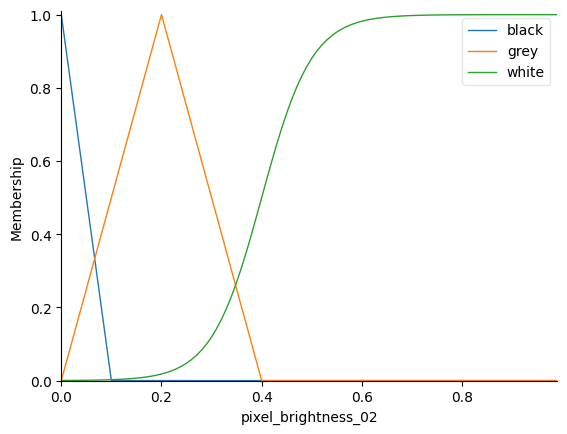

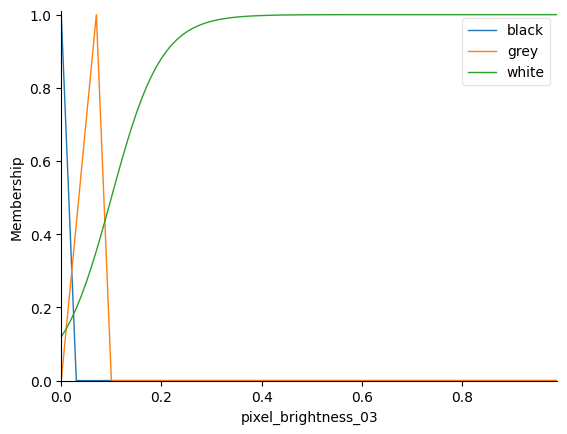

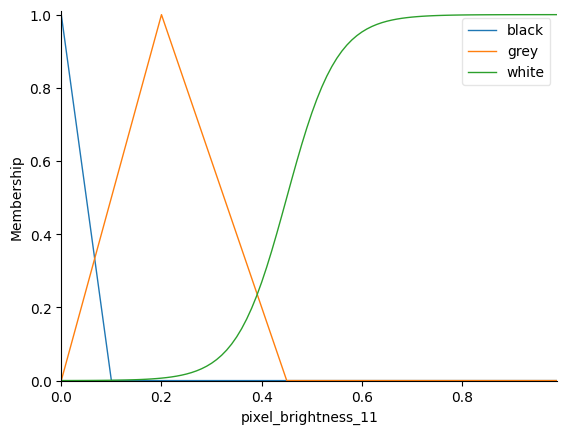

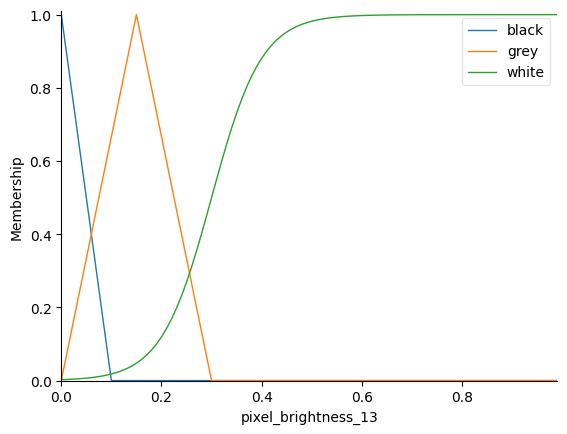

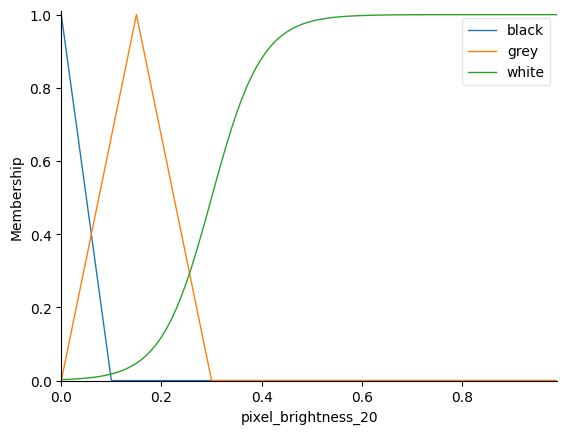

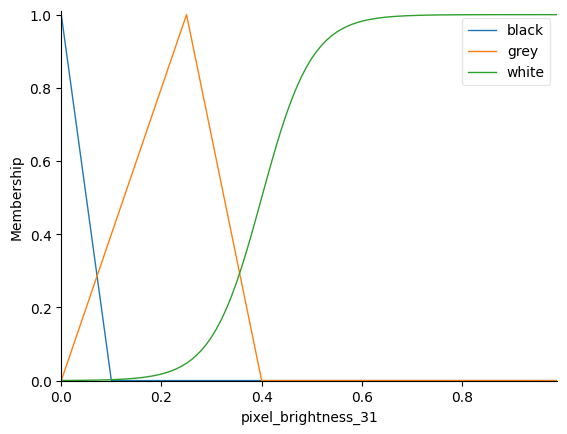

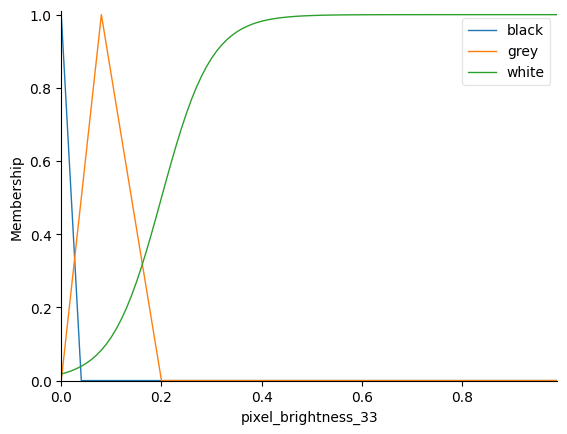

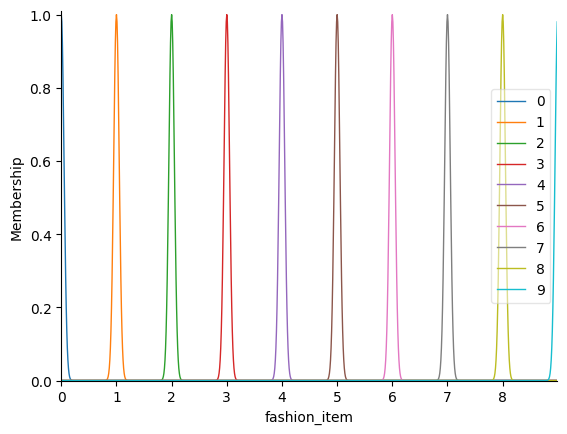

In [ ]:
pixel_brightness_02.view()
pixel_brightness_03.view()
pixel_brightness_11.view()
pixel_brightness_13.view()
pixel_brightness_20.view()
pixel_brightness_31.view()
pixel_brightness_33.view()
fashion_item.view()

In [ ]:
# Setting Rules
rule_0 = ctrl.Rule(pixel_brightness_02['white'] & pixel_brightness_13['grey'] & pixel_brightness_31['white'], fashion_item['0'])
rule_1 = ctrl.Rule(pixel_brightness_02['white'] & pixel_brightness_20['black'] & pixel_brightness_31['grey'], fashion_item['1'])
rule_2 = ctrl.Rule(pixel_brightness_02['white'] & pixel_brightness_03['grey'] & pixel_brightness_33['white'], fashion_item['2'])
rule_3 = ctrl.Rule(pixel_brightness_13['black'] & pixel_brightness_31['white'], fashion_item['3'])
rule_4 = ctrl.Rule(pixel_brightness_03['black'] & pixel_brightness_31['white'] & pixel_brightness_33['white'], fashion_item['4'])
rule_5 = ctrl.Rule(pixel_brightness_02['grey'] & pixel_brightness_20['grey'] & pixel_brightness_31['grey'], fashion_item['5'])
rule_6 = ctrl.Rule(pixel_brightness_02['white'] & pixel_brightness_03['grey'] & pixel_brightness_31['white'], fashion_item['6'])
rule_7 = ctrl.Rule(pixel_brightness_02['black'] & pixel_brightness_20['white'] & pixel_brightness_31['black'], fashion_item['7'])
# rule_7 = ctrl.Rule(pixel_brightness_02['black'] | pixel_brightness_31['black'] & pixel_brightness_20['white'], fashion_item['7'])
rule_8 = ctrl.Rule(pixel_brightness_11['white'] & pixel_brightness_13['white'] & pixel_brightness_20['white'], fashion_item['8'])
rule_9 = ctrl.Rule(pixel_brightness_11['black'] & pixel_brightness_13['white'] & pixel_brightness_20['grey'], fashion_item['9'])

# Control System
fuzzy_control_system = ctrl.ControlSystem([rule_0, rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8, rule_9])

# Simulation
fuzzy_simulator = ctrl.ControlSystemSimulation(fuzzy_control_system)

In [ ]:
# Result DataFrame
result = {
    'prediction': [],
    'prediction2': [],
    'actual': y_test.tolist()
}

# Process Test Data
test_df = pd.concat([
    pd.DataFrame(x_test_new, columns=['00', '01', '02', '03', '10', '11', '12', '13', '20', '21', '22', '23', '30', '31', '32', '33']),
    pd.Series(y_test, name='apparel')],
    axis='columns'
)

for i, row in test_df.iterrows():

    for pos in ['02', '03', '11', '13', '20', '31', '33']:
        fuzzy_simulator.input[f'pixel_brightness_{pos}'] = row[pos]

    # Make Prediction
    fuzzy_simulator.compute()
    result['prediction'] += [fuzzy_simulator.output['fashion_item']]
    result['prediction2'] += [fuzzy_simulator.output['fashion_item'].astype(int)]

In [ ]:
# View Prediction Result
pd.DataFrame({
    'fuzzy_pred': result['prediction'],
    'fuzzy_pred_class': result['prediction2'],
    'actual_class': y_test
})

,fuzzy_pred,fuzzy_pred_class,actual_class
0,8.771823,8,9
1,8.000000,8,2
2,2.547435,2,1
3,1.710885,1,1
4,8.000000,8,6
...,...,...,...
9995,6.187591,6,9
9996,1.916260,1,1
9997,3.063686,3,8
9998,1.609233,1,1


In [ ]:
# Measure Prediction Metrics
rmse = np.sqrt(mean_squared_error(result['actual'], result['prediction']))
acc = accuracy_score(result['actual'], result['prediction2'])

print(f'rmse: {rmse}, accuracy: {acc}')

rmse: 2.616833334790264, accuracy: 0.2533
